In [1]:
import pandas as pd
import os
import numpy  as np
import torch

In [2]:

from torch_geometric.data import Data
data_dir = '../../datasets/m4a-onion-updated-20241210'
processed_data_dir = '../../processed_data/m4a-onion'
# read train, valid, and test datasets
train = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_train.parquet'))
valid = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_val.parquet'))
test = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_test.parquet'))
all_df = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_all.parquet'))

track_id_mapping = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_track_mapping.parquet'))
track_id_mapping = {track_id: graph_track_id for _, (track_id, graph_track_id) in track_id_mapping[['track_id', 'graph_track_id']].iterrows()}
user_id_mapping = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_user_mapping.parquet'))
user_id_mapping = {user_id: graph_user_id for _, (user_id, graph_user_id) in user_id_mapping[['user_id', 'graph_user_id']].iterrows()}

# read feature df
feature = pd.read_parquet(os.path.join(data_dir, 'M4A_song features_with img_Final.parquet'))
lyrics_embedding = pd.DataFrame(feature.lyrics_embedding.tolist(), columns = (lyrics_feature_cols := [f'lyrics_{i}' for i in range(768)]))
feature = feature.drop(columns = ['lyrics_embedding'])
## combine lyrics embedding with features
feature = pd.concat([feature, lyrics_embedding], axis = 1)

# Identifying features

In [3]:
import re
# get different feature columns 
id_col = ['id', 'track_id']
lyrics_features_cols = [f'lyrics_{i}' for i in range(768)]
lowlevel_audio_cols = [col for col in feature if 'lowlevel' in col]
cov_audio_cols = [col for col in feature if 'cov' in col]
mfcc_audio_cols = [col for col in feature if 'MFCC' in col]
rhythm_audio_cols = [col for col in feature if 'rhythm.' in col]
tonal_audio_cols = [col for col in feature if ('tonal' in col) and (col.lower() != 'microtonal')]
metadata_audio_cols = [col for col in  feature if 'metadata' in col]
max_image_cols = [col for col in feature if re.match(r'max\d{4}', col)]
mean_image_cols = [col for col in feature if re.match(r'mean\d{4}', col)]
highlevel_audio_cols = ['release', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo']
song_context_cols = ['popularity', 'duration_ms',]
misc_cols = [ 'artist', 'song', 'lang', 'spotify_id', 'tags', 'album_name', 'genres', '(tag, weight)', 'microtonal']
genre_cols = [col for col in feature if col not in (id_col + lyrics_features_cols + lowlevel_audio_cols + cov_audio_cols + mfcc_audio_cols + rhythm_audio_cols + tonal_audio_cols + metadata_audio_cols + max_image_cols + mean_image_cols +  song_context_cols + misc_cols + highlevel_audio_cols )]

# types of features to keep
lyrics_features = lyrics_features_cols # 768
audio_features = lowlevel_audio_cols + cov_audio_cols + mfcc_audio_cols + rhythm_audio_cols + tonal_audio_cols + highlevel_audio_cols + song_context_cols # 175?
image_features = mean_image_cols # 2048
# all_features = lyrics_features + audio_features + image_features
all_features = lyrics_features + audio_features + image_features


def get_features(feature, feature_cols):
    return feature[feature_cols]



# Creating Graph

## Creating feature vector 

In [4]:
feature['graph_track_id'] = feature['track_id'].map(track_id_mapping)
feature = feature.sort_values(by = 'graph_track_id')
trimmed_features = feature[all_features].values
user_features = np.zeros((len(user_id_mapping), trimmed_features.shape[1]))
node_features = torch.concat([torch.tensor(trimmed_features, dtype = torch.float32), torch.tensor(user_features, dtype = torch.float32)], dim = 0)

## Creating edge index

In [5]:
from sampling import get_aux_candidates, get_existing_edges, get_sorted_tracks_by_timestamp, sample_negative_edges

def create_graph(data, all_df, track_features, track_id_mapping, user_id_mapping, selected_features = None):
    track_features = track_features.copy()
    if selected_features is not None:
        trimmed_features = track_features[selected_features]
    else:
        trimmed_features = track_features
    user_features = np.zeros((len(user_id_mapping), trimmed_features.shape[1]))
    node_features = torch.concat(
        [torch.tensor(trimmed_features.values, dtype = torch.float32),
        torch.tensor(user_features, dtype = torch.float32)], dim = 0
    )
    
    existing_edges = get_existing_edges(all_df)
    ts_tracks = get_sorted_tracks_by_timestamp(all_df)
    aux_candidates = get_aux_candidates(track_features, track_id_mapping, release_year= 2018)
    users, pos_edge_index, neg_edge_index = sample_negative_edges(data, ts_tracks, existing_edges, aux_candidates)
    
    pos_edge_array = np.array(pos_edge_index)
    neg_edge_array = np.array(neg_edge_index)
    u_t, i_t = (
        torch.tensor(pos_edge_array[:, 0 ]),
        torch.tensor(pos_edge_array[:, 1])
    )
    edge_index = torch.stack((torch.cat([u_t, i_t]), torch.cat([i_t, u_t])), dim=0)
    graph = Data(x = node_features, edge_index = edge_index)
    return graph, pos_edge_array, neg_edge_array

full_graph, full_positive_edges, full_negative_edges = create_graph(all_df, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
    

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_layers=3):
        super(SimpleGNN, self).__init__()
        self.layers = torch.nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(input_features, hidden_dim, aggr='sum'))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim, aggr='sum'))
        
        # Output layer
        self.layers.append(GCNConv(hidden_dim, hidden_dim, aggr='sum'))

    def forward(self, data):
        self.initial_x = data.x
        x = data.x
        for layer in self.layers[:-1]:
            x = layer(x, data.edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.layers[-1](x, data.edge_index)
        return F.sigmoid(x)
    

In [7]:
from tqdm import tqdm
num_users = len(user_id_mapping)
num_tracks = len(track_id_mapping)
print("num_users:", num_users)
print("num_tracks:", num_tracks)# BPR loss function



import random as rd
from sampling import get_aux_candidates, get_existing_edges, get_sorted_tracks_by_timestamp, sample_negative_edges

def compute_bpr_loss(users_emb, pos_emb, neg_emb, lambda_reg=1e-4):
    # Compute the standard BPR loss
    pos_scores = (users_emb * pos_emb).sum(dim=1)  # Dot product for positive pairs
    neg_scores = (users_emb * neg_emb).sum(dim=1)  # Dot product for negative pairs

    # BPR loss
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    # Compute L2 regularization on embeddings
    # Here we regularize user, positive item, and negative item embeddings.
    # Adjust which embeddings to regularize depending on your model's needs.
    reg_loss = (users_emb.norm(2).pow(2) +
                pos_emb.norm(2).pow(2) +
                neg_emb.norm(2).pow(2)) / users_emb.size(0)

    # Add regularization term scaled by lambda_reg
    total_loss = bpr_loss + lambda_reg * reg_loss
    return total_loss

import numpy as np
import torch

def get_mrr(user_embs, track_embs, num_tracks, test, all_data, test_candidates = None):
  relevance_score = torch.matmul(user_embs, torch.transpose(track_embs, 0, 1))

  def sample_mrr_candidates(all_pos_tracks, pos_track, num_candidates):
    candidates = []
    candidates.append(pos_track)
    while len(candidates) < num_candidates:
      candidate = rd.choice(range(num_tracks))
      if candidate not in candidates and candidate not in all_pos_tracks:
        candidates.append(candidate)
    return candidates

  mrr = []

  for test_user, group in test.groupby('graph_user_id'):
    all_pos_tracks = all_data.loc[all_data['graph_user_id'] == test_user, 'graph_track_id']

    for test_track in group['graph_track_id']:
      # the first candidate is the positive one
      if test_candidates is None:
        candidates = sample_mrr_candidates(all_pos_tracks, test_track, num_candidates=20)
      else: 
        candidates = test_candidates[test_track]
      user_scores =  relevance_score[test_user-num_tracks, candidates].clone()
      sorted_indices = torch.argsort(user_scores, descending=True)
      # the positive track is always the first in candidates list
      rank = sorted_indices.tolist().index(0) + 1
      reciprocal_rank = 1.0 / rank
      mrr.append(reciprocal_rank)

  return sum(mrr)/len(mrr)


num_users: 2312
num_tracks: 32685


In [18]:
HIDDEN_DIM = 256
N_LAYERS = 5
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.001
LR = 0.0001
K = 20

In [19]:
device = 'cuda'

model = SimpleGNN(input_features = len(all_features), hidden_dim = HIDDEN_DIM, num_layers = N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# Training settings
patience = None #  Number of epochs to wait for improvement before stopping
early_stopping_counter = 0
best_validation_loss = float('inf')

model.train()  # Ensure the model is in training mode

train_losses = []
valid_losses = []
valid_mrr = []
for epoch in range(EPOCHS):
    if epoch % 1 == 0:
        train_graph, train_positive_edges, train_negative_edges = create_graph(train, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
        valid_graph, valid_positive_edges, valid_negative_edges = create_graph(valid, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
        
        train_graph.to(device)
        valid_graph.to(device)


    # Training step
    optimizer.zero_grad()
    edge_out = model(train_graph)
    user_nodes = train_positive_edges[:, 0]
    pos_nodes = train_positive_edges[:, 1]
    neg_nodes = train_negative_edges[:, 1]
    train_loss = compute_bpr_loss(edge_out[user_nodes], edge_out[pos_nodes], edge_out[neg_nodes])
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_out = model(valid_graph).cpu()
        user_nodes = valid_positive_edges[:, 0]
        pos_nodes = valid_positive_edges[:, 1]
        neg_nodes = valid_negative_edges[:, 1]
        val_loss = compute_bpr_loss(val_out[user_nodes], val_out[pos_nodes], val_out[neg_nodes])
        user_map = [val for val in user_id_mapping.values()]
        item_map = [val for val in track_id_mapping.values()]
        mrr = get_mrr(val_out[user_map], val_out[item_map], num_tracks, valid, all_df)

        # Store losses for plotting
    train_losses.append(train_loss.item())
    valid_losses.append(val_loss.item())
    valid_mrr.append(mrr)
    
    model.train()  # Set the model back to training mode

    if patience is not None:
        # Early stopping logic
        if val_loss < best_validation_loss:
            best_validation_loss = val_loss
            early_stopping_counter = 0  # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Print losses for each epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, MRR: {mrr}")


Epoch: 0, Training Loss: 1.5841929912567139, Validation Loss: 0.5299509167671204, MRR: 0.6720031982134034
Epoch: 1, Training Loss: 1.4733036756515503, Validation Loss: 0.48115479946136475, MRR: 0.6077023069037575
Epoch: 2, Training Loss: 1.355034351348877, Validation Loss: 0.42436477541923523, MRR: 0.6066809009759748
Epoch: 3, Training Loss: 1.2565819025039673, Validation Loss: 0.4102425277233124, MRR: 0.582397839893542
Epoch: 4, Training Loss: 1.1857578754425049, Validation Loss: 0.4310549795627594, MRR: 0.527555115184343
Epoch: 5, Training Loss: 1.1770251989364624, Validation Loss: 0.42738887667655945, MRR: 0.563588772903765
Epoch: 6, Training Loss: 1.1158493757247925, Validation Loss: 0.46028852462768555, MRR: 0.6131031496326746
Epoch: 7, Training Loss: 1.076160192489624, Validation Loss: 0.47126010060310364, MRR: 0.6476588612966647
Epoch: 8, Training Loss: 1.0355744361877441, Validation Loss: 0.4436841309070587, MRR: 0.6198533167289106
Epoch: 9, Training Loss: 1.0494767427444458, V

In [20]:
len(all_features)

2989

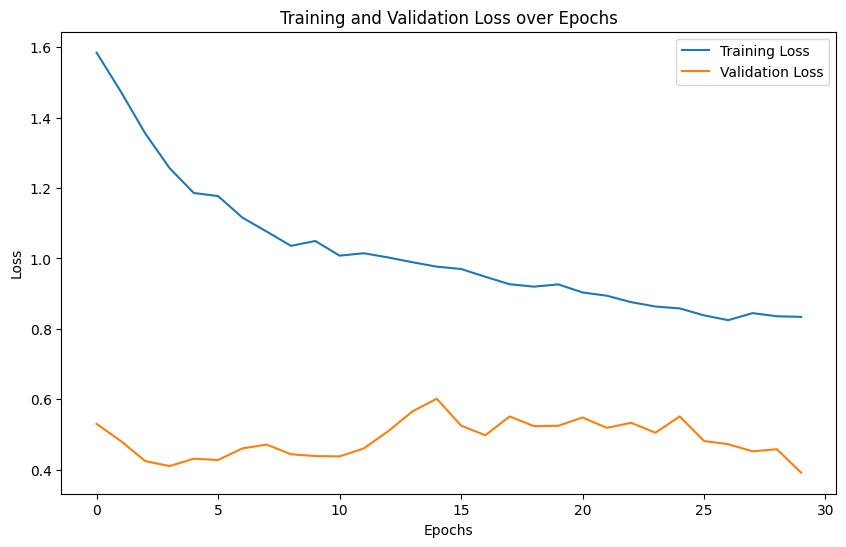

In [21]:
import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


C:\Users\Gaurav Anand\AppData\Local\Temp\ipykernel_20084\1598709989.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


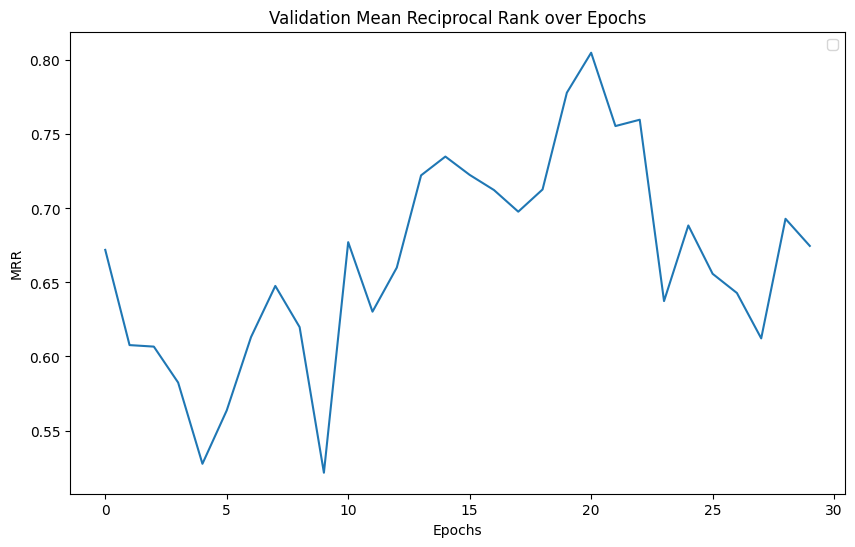

In [22]:
import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(valid_mrr)
plt.xlabel('Epochs')
plt.ylabel('MRR')
plt.legend()
plt.title('Validation Mean Reciprocal Rank over Epochs')
plt.show()


Save results

In [28]:
import pandas as pd
import zipfile
import pickle

results_folder = '../../models/'



def eval_results(test, model):
    # CHANGE THIS FOR LIGHTGCN
    test_graph, test_positive_edges, test_negative_edges = create_graph(test, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
    test_graph.to(device)
    model.eval()
    test_candidates = {graph_track_id: test_cand_list for _, (graph_track_id, test_cand_list) in test[['graph_track_id', 'test_candidates']].iterrows()}
    with torch.no_grad():
        user_map = [val for val in user_id_mapping.values()]
        item_map = [val for val in track_id_mapping.values()]
        test_out = model(test_graph).cpu()
        mrr = get_mrr(test_out[user_map], test_out[item_map], num_tracks, test, all_df, test_candidates = test_candidates)
    return mrr
    
def get_results(test_res, valid_res_list, valid_loss_list, train_loss_list):
    df = pd.DataFrame({
        'test_result': [test_res],
        'valid_results': [valid_res_list],
        'valid_losses': [valid_loss_list],
        'train_losses': [train_loss_list]
    })
    return df

def zip_dataframe_and_model(df, model, folder_path, zip_filename):
    """
    Zips a Pandas DataFrame and a model into a specified folder.

    Args:
        df (pd.DataFrame): The DataFrame to zip.
        model: The model object to zip.
        folder_path (str): The path to the folder where the zip file will be created.
        zip_filename (str): The name of the zip file.
    """
    
    with zipfile.ZipFile(f"{folder_path}/{zip_filename}", 'w') as zipf:
        # Save DataFrame to CSV and add to zip
        df.to_csv("results.csv", index=False)
        zipf.write("results.csv")

        # Save model to pickle and add to zip
        with open("model.pkl", 'wb') as model_file:
            pickle.dump(model, model_file)
        zipf.write("model.pkl")
        
test_mrr = eval_results(test, model)
results_df = get_results(test_mrr, valid_mrr, valid_losses, train_losses)
zip_dataframe_and_model(results_df, model, folder_path = results_folder, zip_filename = 'gnn_7layers_all_features')

0


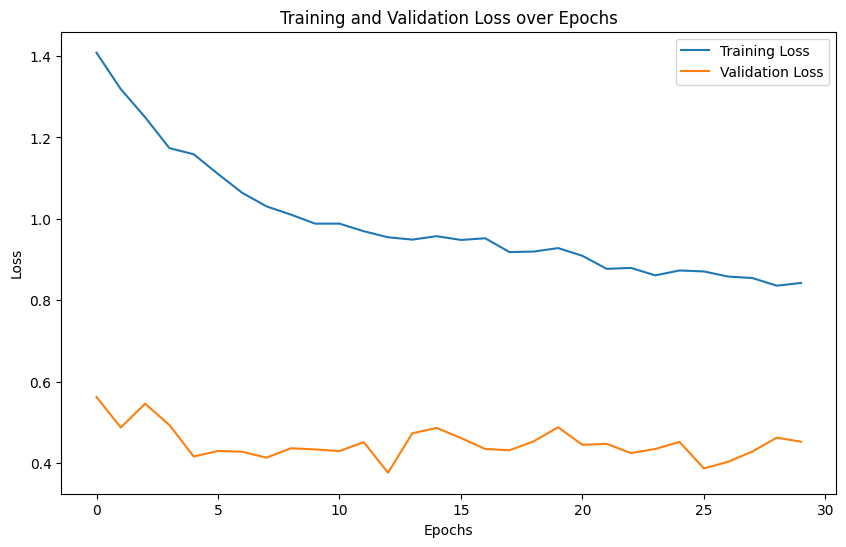

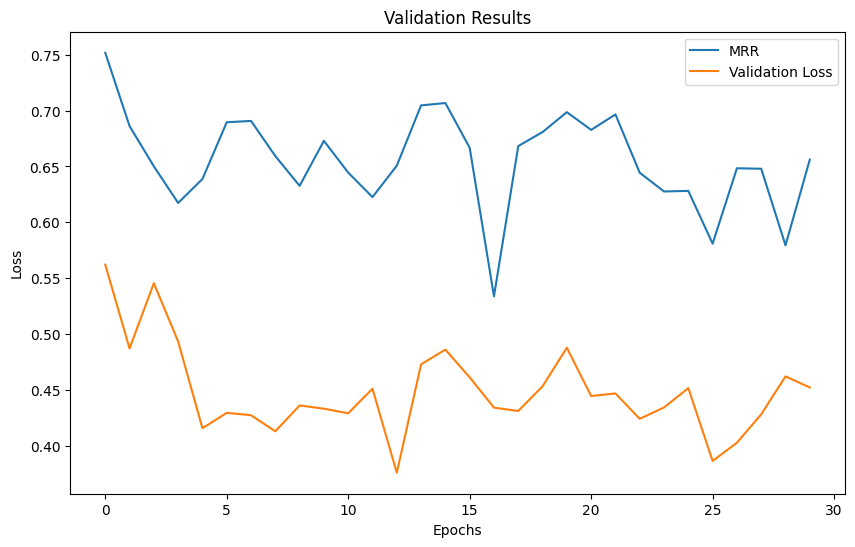

In [23]:
import pandas as pd
import zipfile
import pickle
import os

def extract_model_and_results(zip_filepath):

    # Create a temporary directory to extract files
    temp_dir = "temp_extract"
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zipf:
            zipf.extractall(temp_dir)
            results_df = pd.read_csv(os.path.join(temp_dir, "results.csv"))
            with open(os.path.join(temp_dir, "model.pkl"), 'rb') as model_file:
                model = pickle.load(model_file)
                
        return results_df, model
        
    finally:
        if os.path.exists(os.path.join(temp_dir, "results.csv")):
            os.remove(os.path.join(temp_dir, "results.csv"))
        if os.path.exists(os.path.join(temp_dir, "model.pkl")):
            os.remove(os.path.join(temp_dir, "model.pkl"))
        if os.path.exists(temp_dir):
            os.rmdir(temp_dir)

# Example usage:
zip_path = "../../models/gnn_5layers_model"
results_df, loaded_model = extract_model_and_results(zip_path)

for i, (test_result, valid_results, valid_losses, train_losses) in results_df.iterrows():
    print(i)
    
valid_mrr = [float(x) for x in valid_results.strip('[').strip(']').split(',')]
valid_losses = [float(x) for x in valid_losses.strip('[').strip(']').split(',')]
train_losses = [float(x) for x in train_losses.strip('[').strip(']').split(',')]

import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(valid_mrr, label='MRR')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Results')
plt.show()

